<a href="https://colab.research.google.com/github/samurai-kai/ME570/blob/main/Final_MultiOutput_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import wandb
import cv2
import tensorflow as tf
from scipy.signal import medfilt

In [57]:
# Connect to Google Drive
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Update 'base_dir' with the path to your private workspace on Google Drive
base_dir = '/content/drive/MyDrive/00_Workspace'

if not os.path.exists(base_dir):
  raise FileNotFoundError(f'Base directory {base_dir} does not exist')

## Utils

In [58]:
# Weighting the straights 5× higher did not lead to good results in practice,
# possibly because the model still saw too many curves during training.

# Simply reducing the number of curves (i.e. using a balanced dataset)
# worked better by forcing the model to learn from both classes equally.

# Define weighted sparse categorical crossentropy
def weighted_sparse_categorical_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        weights = tf.gather(class_weights, y_true)

        ce = tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
        return tf.multiply(ce, weights)  # Element-wise multiply

    return loss_fn

In [59]:
def median_filter(data, kernel_size=5):
    return medfilt(data, kernel_size=kernel_size)

def preprocess_images(im_selected, ymin=120, ymax=265):
    """
    Preprocess a list of RGB images for input into a TensorFlow model.

    Steps:
    - Crop the vertical range of each image from ymin to ymax (e.g., remove sky and hood).
    - Convert the cropped image to grayscale.
    - Normalize pixel values to the range [0, 1].
    - Add a channel dimension to match TensorFlow's expected input shape.

    Args:
        im_selected (List[np.ndarray]): List of RGB images as NumPy arrays (H, W, 3).
        ymin (int): Starting row index for cropping.
        ymax (int): Ending row index for cropping.

    Returns:
        np.ndarray: Array of shape (N, ymax - ymin, W, 1) with float32 grayscale images.
    """
    processed = []
    for img in im_selected:
        # Crop image vertically to remove irrelevant areas (e.g., sky, car hood)
        img_cropped = img[ymin:ymax]

        # Convert the cropped image to grayscale (1 channel)
        gray = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)

        # Normalize pixel values to the range [0, 1]
        norm = gray.astype(np.float32) / 255.0

        # Add channel dimension to match model input shape (H, W, 1)
        processed.append(np.expand_dims(norm, axis=-1))

    # Return a NumPy array of shape (N, H, W, 1)
    return np.array(processed, dtype=np.float32)


def filter_min_distance(idx, min_distance=10):
    # Given a list of indices, return a subset where each index is at least
    # `min_distance` apart from the previous one.
    #
    # Example:
    #   idx = [1, 2, 3, 4, 5, 15]
    #   filter_min_distance(idx, min_distance=10) -> [1, 15]
    #
    # Explanation:
    #   - Start with 1
    #   - Skip 2–5 because they're too close to 1
    #   - 15 is far enough from 1 (15 - 1 = 14 >= 10), so it's added

    # Convert input to sorted NumPy array
    idx = np.sort(np.array(idx))
    selected = []

    for i in idx:
        # Add the index if this is the first one,
        # or if it's at least `min_distance` away from the last selected
        if not selected or i - selected[-1] >= min_distance:
            selected.append(i)

    # Return the filtered indices as a NumPy array
    return np.array(selected)


def sample_balanced_with_flipping(y, images, bins=9, min_distance=10):
    """
    Augments data by flipping, balances bins, and filters for minimum spacing.

    Parameters:
    - y: 1D numpy array of steering angles
    - images: numpy array of shape (N, H, W, C)
    - bins: number of histogram bins
    - min_distance: minimum index spacing in each bin

    Returns:
    - y_selected: filtered and balanced steering angles
    - im_selected: corresponding selected images
    """
    y = np.array(y)
    images = np.array(images)

    # Flip images and angles
    images_flipped = np.flip(images, axis=2)
    y_flipped = -y

    # Concatenate originals and flipped
    y_combined = np.concatenate([-y, y])
    images_combined = np.concatenate([images_flipped, images], axis=0)

    # Bin edges
    _, edges = np.histogram(y_combined, bins=bins)

    # Filtered bin-wise indices
    filtered_bins = []
    for i in range(len(edges) - 1):
        idx = np.where((y_combined >= edges[i]) & (y_combined < edges[i+1]))[0]
        filtered = filter_min_distance(idx, min_distance)
        filtered_bins.append(filtered)

    # Global N: minimum filtered size per bin
    N = min(len(b) for b in filtered_bins if len(b) > 0)

    # Select up to N indices per bin
    selected_indices = []
    for idx in filtered_bins:
        if len(idx) == 0:
            continue
        sel = np.linspace(0, len(idx) - 1, min(N, len(idx)), dtype=int)
        selected_indices.extend(idx[sel])

    selected_indices = np.array(selected_indices)

    # Final selection
    y_selected = y_combined[selected_indices]
    im_selected = images_combined[selected_indices]

    return y_selected, im_selected, selected_indices


In [60]:
class LidarToImageProjector:

  def __init__(self, K, T, im_w = 640, im_h = 360):
      self.K = K
      self.T = T
      self.im_w = im_w
      self.im_h = im_h

  def project_points_to_image(self, pts):
    # Add homogeneous coordinate
    pts_homo = np.hstack((pts, np.ones((pts.shape[0], 1))))

    # Transform from Lidar to Camera frame
    pts_transformed = (self.T @ pts_homo.T).T

    # Remove Lidar points that are behind the camera
    # Otherwise they would be incorrectly projected onto the image
    pts_transformed = pts_transformed[pts_transformed[:,2] > 1e-6]

    # Depth values (z)
    z = pts_transformed[:, 2]

    # Project to image plane
    pts_2d = self.K @ pts_transformed[:, :3].T

    # Perspectiv devision: f * x / z, f * y / z
    pixels = (pts_2d[:2] / pts_2d[2]).T

    # Remove pixels outside image boundaries
    x, y = pixels.T
    mask = (x >= 0) & (x < self.im_w) & (y >= 0) & (y < self.im_h)
    pixels = pixels[mask]
    z = z[mask]

    return pixels, z

In [61]:
# Lidar frame:   x-forward, y-left, z-down   (left-handed)
# Camera frame:  x-right,  y-down,  z-forward (right-handed OpenCV/ROS optical frame)

# Base rotation to align LiDAR frame with camera frame (without additional rotation)
R_base = np.array([
    [0,  -1,  0],
    [0,   0, -1],
    [1,   0,  0]
])

# Additional LiDAR rotation: 225 degrees (clockwise) around Z-axis
theta = np.deg2rad(228)
R_rot = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])

# Final rotation: apply additional -45° Z-rotation on top of base rotation
R = R_base @ R_rot

# Translation from LiDAR to Camera in meters (x, y, z) in camera coordinates.
# Note: In the camera frame, +Y points down in the image — so adjusting the Y value moves the point cloud up or down in the image.
t = np.array([[-0.0015, -0.06, -0.04]])

# Combine into 3x4 transformation matrix
T = np.hstack((R, t.T))

In [62]:
def get_bounding_boxes(predictions, objects_3d):

    # Check if there are any predictions
    if len(predictions) == 0:
        return False, None

    p = predictions[0].cpu()  # Get the first prediction (move to CPU)
    all_boxes = p.boxes  # Access the bounding boxes
    ids = all_boxes.cls.numpy()  # Class IDs for each detected object
    confidences = all_boxes.conf.numpy()  # Confidence scores for each detection

    detections = {}
    for id, lbl in objects_3d.items():
      # Check if the class ID is present in the predictions
      if id in ids:

        # Filter the boxes with the target ID
        boxes = all_boxes[ids == id]
        conf = confidences[ids == id]

        # Take the bbox with the highest confidence
        corners = boxes.xyxy[np.argmax(conf)].numpy()

        # Extract the center and size (xyxy) of the box with the highest confidence
        detections[id] = {'name': lbl, 'corners': corners}

    if len(detections) == 0:
      return False, None
    else:
      return True, detections

def get_onnx_boxes(predictions, objects_3d):

    # Check if there are any predictions
    if len(predictions) == 0:
        return False, None

    p = predictions[0]  # Get the first prediction

    all_boxes = np.array(p.boxes)  # Access the bounding boxes
    ids = np.array(p.class_ids) # Class IDs for each detected object
    confidences = np.array(p.scores)  # Confidence scores for each detection

    detections = {}
    for id, lbl in objects_3d.items():
      # Check if the class ID is present in the predictions
      if id in ids:

        # Filter the boxes with the target ID
        boxes = all_boxes[ids == id]
        conf = confidences[ids == id]

        # Extract the center and size (xyxy) of the first box
        corners = boxes[np.argmax(conf)]

        # Extract the center and size (xyxy) of the box with the highest confidence
        detections[id] = {'name': lbl, 'corners': corners}

    if len(detections) == 0:
      return False, None
    else:
      return True, detections

In [63]:
def plot_result(image, pixels, depth, boxes=None):
    x, y = pixels.T

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x, y, s=6.0, marker='+', c=depth, cmap='viridis')  # color by depth
    plt.imshow(image)
    plt.colorbar(sc, label='Depth (Z in camera frame)')
    plt.title("Projected LiDAR Points Colored by Depth")
    plt.axis("off")

    # Add legend if boxes are provided
    if boxes:
        handles = []
        labels = []
        for box in boxes.values():
            label = f"{box['name']}: {box['z']:.1f}m"
            # Create dummy handle (invisible) for legend entry
            h = plt.Line2D([], [], marker='o', label=label)
            handles.append(h)
            labels.append(label)
        plt.legend(handles=handles, loc='upper left')

    plt.show()

## Load Data

In [64]:
# Connect to Foxglove
!pip install -qq git+https://github.com/william-mx/foxglove-bag-reader.git
from foxglove_bag_reader import BagfileReader

API_KEY = "fox_sk_j4qRQHhh0cd8mgMAQzDXNPwhGEfkLOXe"
r = BagfileReader(API_KEY)
r.print_recordings()

  Preparing metadata (setup.py) ... done
Available Recordings:

bshaped_track_all                        → 2y57fL95RUnUG5MW
bshaped_track_depth                      → rec_0dY0zYREG8TYFbTY
bshaped_track_following_left             → rec_0dX26NC9WkjKqTyi
bshaped_track_following_right            → rec_0dX27U8jsoFpbA2u
bshaped_track_odometry                   → rec_0dY0ylXuthVmxy44
circle_drive_fixed_speed_left            → rec_0dWf0XUVbrIrRtgL
cones_lidar_slam                         → rec_0dY0z7WHao9tYAZY
hallway_lidar_slam                       → rec_0dY106wizvoNRenI
imu_speed_stairs                         → rec_0dWf0csWqOJcTgWT
imu_static                               → rec_0dWf1wPygPWHB8ne
ir_lidar_calibration                     → rec_0dY10RmyGbqo3RYh
lidar_erpm_speed_calibration             → rec_0dWeOf9soScOfuPB
lidar_intensity_chessboard               → rec_0dY11K7XVJTQjkJp
line_follow_ir                           → rec_0dXdQXXtgpulyhFq
line_follow_rgb                          → r

## Get YOLO and LIDAR fused data


In [76]:
# List of bagfile names to process
names = ['bc_acc_right_lidar', 'bc_acc_left_lidar']

y_angles = []     # List to store steering angles from all files
all_images = []   # List to store preprocessed images from all files
y_speed = []      # List to store speed values from all files

for name in names:
    print(f"Parsing: {name}")

    # Open the specific bagfile recording by name
    r.get_recording_by_name(name)

    # Load steering command messages (AckermannDrive) and camera frames into DataFrames
    df_ackermann = r.parse_topic('/rc/ackermann_cmd')
    df_camera = r.parse_topic('/camera/camera/color/image_raw')

    # Synchronize image and steering angle data based on timestamps
    df_synced = r.sync_dataframes(df_camera, ack=df_ackermann)

    # Extract the ground truth steering angles
    y = df_synced['steering_angle_ack'].values
    y_filtered = median_filter(y, kernel_size = 9)

    # Load driving events that were manually defined in Foxglove (e.g. for labeling segments)
    events = r.get_events()

    # Match each event to the corresponding image indices in the synced DataFrame
    events = r.find_indices_within_events(df_camera, events)

    # Speed levels
    speed_indices = np.zeros_like(y, np.uint8)

    for event in events:

        if event['metadata'].get('segment') == 'straight':

          idx = np.array(event['indices'])  # Get indices for this event

          speed_indices[idx] = 1


    # Since the dataset is augmented by flipping all images,
    # we also need to duplicate the speed labels to match the new data
    speed_indices = np.concatenate([speed_indices, speed_indices])

    # Extract all raw RGB images from the camera topic
    images = r.get_all_images("/camera/camera/color/image_raw")

    # Balance the dataset and augment it by flipping images and angles
    # This helps the model generalize better and reduces steering bias
    y_selected, im_selected, selected_indices = sample_balanced_with_flipping(y_filtered, images)

    # Select the corresponding speed labels for the sampled training indices
    speed_selected = speed_indices[selected_indices]

    # Convert selected angles to float32 for training
    y_train_ = y_selected.astype(np.float32)  # Shape: (N,)

    # Preprocess selected images: crop, grayscale, normalize, add channel dim
    x_train_ = preprocess_images(im_selected)  # Shape: (N, H, W, 1)

    # Append processed data to overall dataset
    y_angles.append(y_train_)
    all_images.append(x_train_)
    y_speed.append(speed_selected)

# Concatenate all steering angles and images from different recordings
y_angles = np.concatenate(y_angles)             # Shape: (Total N,)
y_speed = np.concatenate(y_speed)               # Shape: (Total N,)
all_images = np.concatenate(all_images, axis=0) # Shape: (Total N, H, W, 1)

Parsing: bc_acc_right_lidar
Parsing: bc_acc_left_lidar


In [77]:
print(len(y_angles))
print(len(y_speed))
print(len(all_images))

189
189
189


Loading bagfile: bc_acc_right_lidar


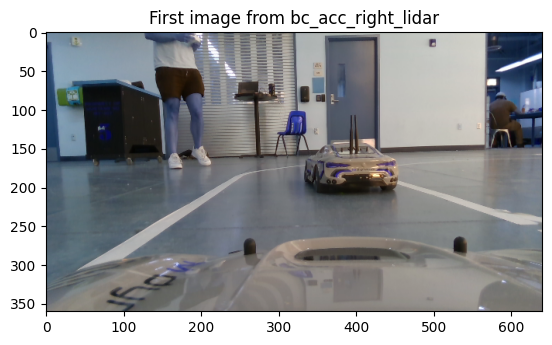

Loading bagfile: bc_acc_left_lidar


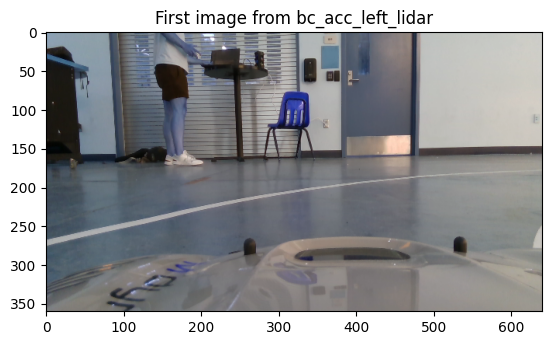

In [66]:
bagfiles = ['bc_acc_right_lidar', 'bc_acc_left_lidar']

all_pointclouds = []
all_images = []

for name in bagfiles:
    print(f"Loading bagfile: {name}")
    r.get_recording_by_name(name)

    # Load data into pandas dataframe
    df_scan = r.parse_topic('/scan')
    df_camera = r.parse_topic('/camera/camera/color/image_raw')

    # Sync dataframes
    df_synced = r.sync_dataframes(df_camera, scan=df_scan)

    # Get images and convert to numpy array
    images = r.get_all_images("/camera/camera/color/image_raw")
    images = np.array(images)

    # Extract pointclouds from synced dataframe
    pointclouds = [np.array(pts) for pts in df_synced['pointcloud_scan'].values]

    # Store or process the loaded data
    all_images.append(images)
    all_pointclouds.append(pointclouds)

    # Optional: show info and first image of this bagfile
    r.info()
    plt.imshow(images[0])
    plt.title(f"First image from {name}")
    plt.show()

# If you want, you can concatenate or further process all_images and all_pointclouds here


In [79]:
print(len(all_pointclouds))
print(len(all_images))

2
189


In [67]:
%pip install -qq ultralytics==8.3.119
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/107.7 GB disk)


In [68]:
model_path = '/content/drive/MyDrive/00_Workspace/models/william_best.pt'
model = YOLO(model_path)

In [69]:
objects_3d = ['car']

id2label = model.names

objects_3d = {id: lbl for id, lbl in id2label.items() if lbl in objects_3d}

objects_3d

{0: 'car'}

In [70]:
# Projector for transforming LiDAR points into camera image
projector = LidarToImageProjector(K, T)

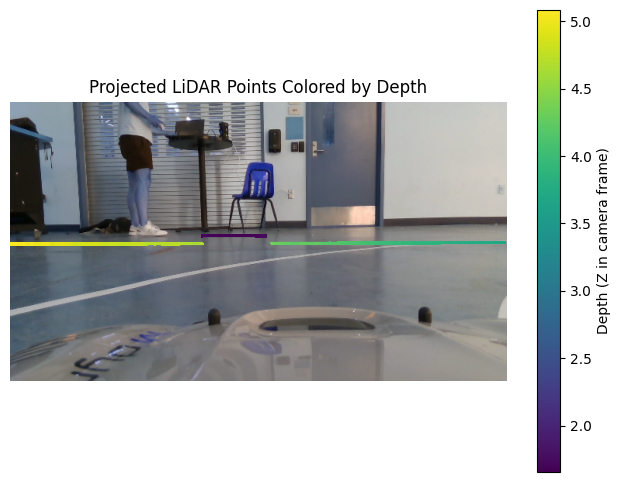

In [82]:
pts = pointclouds[0]
image = images[0]

pixels, depth = projector.project_points_to_image(pts)

plot_result(image, pixels, depth)


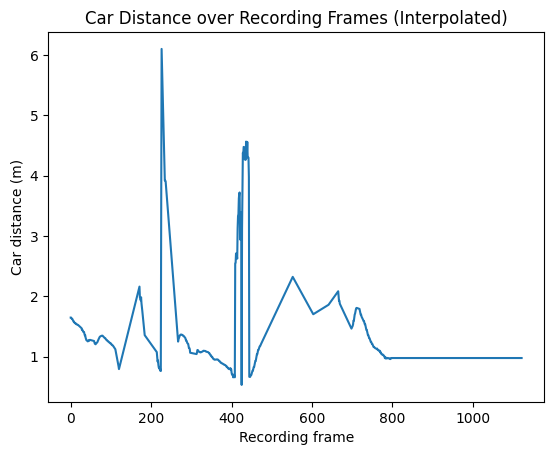

In [83]:
distances = []
max_dist = float('-inf') # Initialize with a very small number
min_dist = float('inf')  # Initialize with a very large number
detection_indices = [] # To store indices where a car is detected
detected_distances = [] # To store distances where a car is detected

# Loop through all frames
for i, (pts, image) in enumerate(zip(pointclouds, images)):

    if i > 799: break

    predictions = model(image, verbose = False)
    success, boxes = get_bounding_boxes(predictions, objects_3d)

    if success:
        detection_indices.append(i)
        # Directly use the distance from the single detected car
        # Assuming there's only one entry in the boxes dictionary
        car_box = list(boxes.values())[0]

        x1, y1, x2, y2 = car_box['corners']
        xmin, xmax = sorted([x1, x2])
        ymin, ymax = sorted([y1, y2])

        # Project 3D points to 2D image coordinates
        pixels, depth = projector.project_points_to_image(pts)
        x, y = pixels.T

        # Create a mask for pixels inside the bounding box
        mask = (x >= xmin) & (x <= xmax) & (y >= ymin) & (y <= ymax)

        # Select corresponding depth values
        z_values = depth[mask]

        if len(z_values) > 0:
            car_distance = np.median(z_values).item()
            detected_distances.append(car_distance)

            max_dist = max(max_dist, car_distance)
            min_dist = min(min_dist, car_distance)
        else:
            # If no depth points fall within the bounding box, append a placeholder
            detected_distances.append(np.nan) # Use NaN as a placeholder
    else:
        # If no car is detected, append None to keep lists aligned
        detection_indices.append(i)
        detected_distances.append(None)


# Now, interpolate for the frames where no car was detected or no valid depth was found
distances = [None] * len(images) # Initialize distances list with None

# Populate distances list with detected values (including np.nan)
for idx, dist in zip(detection_indices, detected_distances):
    distances[idx] = dist

# Fill in the gaps using linear interpolation
for i in range(len(distances)):
    # Check if the distance is None OR np.nan
    if distances[i] is None or (isinstance(distances[i], float) and np.isnan(distances[i])):
        # Find the nearest detected frames before and after the current frame
        prev_detection_idx = None
        for j in range(i-1, -1, -1):
            # Check for non-None and non-NaN values
            if distances[j] is not None and not np.isnan(distances[j]):
                prev_detection_idx = j
                break

        next_detection_idx = None
        for j in range(i+1, len(distances)):
            # Check for non-None and non-NaN values
            if distances[j] is not None and not np.isnan(distances[j]):
                next_detection_idx = j
                break

        if prev_detection_idx is not None and next_detection_idx is not None:
            # Linear interpolation
            prev_dist = distances[prev_detection_idx]
            next_dist = distances[next_detection_idx]
            distances[i] = prev_dist + (next_dist - prev_dist) * (i - prev_detection_idx) / (next_detection_idx - prev_detection_idx)
        elif prev_detection_idx is not None:
            # Extrapolate using the last known distance
            distances[i] = distances[prev_detection_idx]
        elif next_detection_idx is not None:
             # Extrapolate using the next known distance
            distances[i] = distances[next_detection_idx]
        else:
            # If no detection before or after with valid distance, set a default
            distances[i] = 3 # Default to 3 if no detections at all with valid distances

# After interpolation, you can proceed with plotting
plt.plot(distances)
plt.xlabel("Recording frame")
plt.ylabel("Car distance (m)")
plt.title("Car Distance over Recording Frames (Interpolated)")
plt.show()

In [84]:
print(len(distances))
print(len(images))
print(max_dist)
print(min_dist)

1122
1122
6.100360852489204
0.531259654154535


#Apply Speed Calculation Data to Distance Data


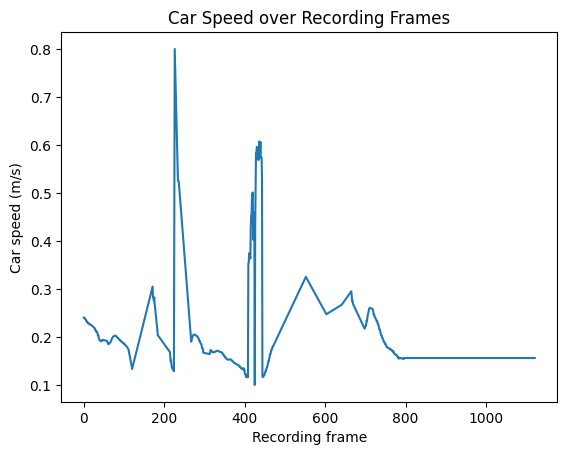

In [110]:
y_speed = [None] * len(distances)  # Initialize speeds list with None

min_speed = 0.1
max_speed = 0.8
# min_dist = 3  # Assuming min_dist is defined as the safe distance
# max_dist = 15 # Assuming max_dist is defined as the maximum distance for speed calculation


for i, distance in enumerate(distances):
    if distance is None or np.isnan(distance):
        # Handle cases where interpolation resulted in None or NaN
        y_speed[i] = 0  # Or some other default speed
    elif distance < min_dist:
        y_speed[i] = 0
    else:
        # Compute how far we are relative to the minimum safe distance (clamped between 0 and 1)
        distance_ratio = max(0.0, min((distance - min_dist) / (max_dist - min_dist), 1.0))

        # Interpolate speed between min_speed and max_speed
        y_speed[i] = min_speed + distance_ratio * (max_speed - min_speed)

plt.plot(y_speed)
plt.xlabel("Recording frame")
plt.ylabel("Car speed (m/s)")
plt.title("Car Speed over Recording Frames")
plt.show()

In [102]:
filepath = base_dir + '/data/pilot_dataset_speed_gt.npz'

# save dataset
# np.savez_compressed(filepath, X=all_images, y_angles=y_angles, y_speed=y_speed)

In [114]:
print(f"Length angle data array: {len(y_angles)}")
print(f"Length image data array: {len(all_images)}")
print(f"Length speed data array: {len(y_speed)}")

Length angle data array: 189
Length image data array: 189
Length speed data array: 1122


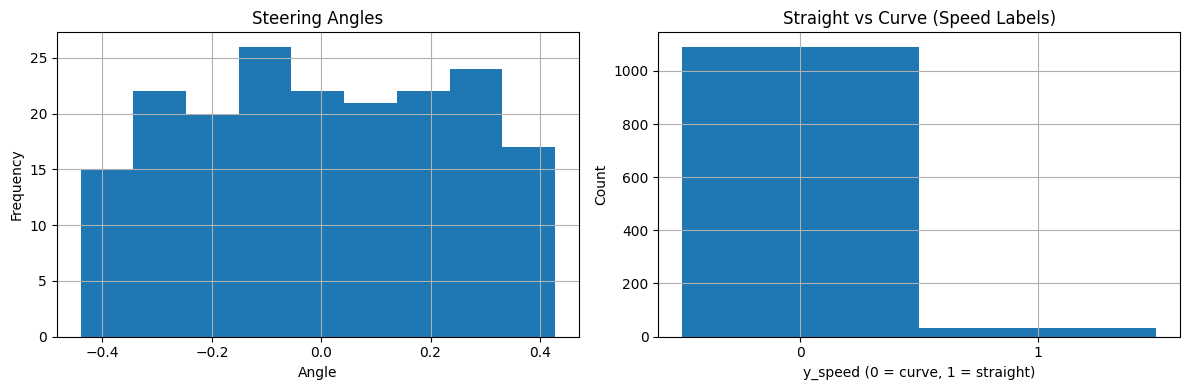

In [105]:
# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of steering angles
axes[0].hist(y_angles, bins=9)
axes[0].set_title("Steering Angles")
axes[0].set_xlabel("Angle")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Histogram of speed labels (0 = curve, 1 = straight)
axes[1].hist(y_speed, bins=[-0.5, 0.5, 1.5])  # Bin edges centered on 0 and 1
axes[1].set_title("Straight vs Curve (Speed Labels)")
axes[1].set_xlabel("y_speed (0 = curve, 1 = straight)")
axes[1].set_ylabel("Count")
axes[1].set_xticks([0, 1])  # Set x-axis ticks to integer labels
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [106]:
filepath = base_dir + '/data/pilot_dataset_speed_gt.npz'

# save dataset
# np.savez_compressed(filepath, X=all_images, y_angles=y_angles, y_speed=y_speed)